In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:

import os
import sys
import getopt
import numpy as np
import networkx as nx
import random
from scipy.sparse import triu

dt = 1
a_steps = 3 # Number of social activity upgrades at each time step

N_sims = 10 # Number of simulation
N = 500 # Number of individuals

delta = np.exp(-dt/10) # Discount factor

# Build the network 

prob = 14.7/N # 14.7 is the average degree

# BEHAVIOUR PARAMETERS

alpha = 21

# BIOLOGICAL PARAMETERS

mu = dt / 10.  # Recovery rate
beta_default = 3 * mu # Transmission rate

# CODE PARAMETERS

i0 = 0.01 # Fraction of initial infected nodes
# frac = 10/N # Only keep runs where the disease reaches this fraction of the population
t_max = round(1000/dt) # Max length of a simulation




In [2]:
def create_random_connected(N, prob, seed=0):
    G = nx.erdos_renyi_graph(N, prob, seed=seed)
    while not nx.is_connected(G):
        G = nx.erdos_renyi_graph(N, prob, seed=seed)
    return G

In [3]:
def get_prev_i(all_links, i_tuple: tuple, k):
    """
    Returns the prevalence of infected nodes in the neighbors of each node the network
    
    Parameters:
    all_links: array
        An array of all the links in the network,
        all_links = np.array(nx.adjacency_matrix(G).nonzero()).T
    i_tuple: tuple
        A tuple with all the infected nodes
    k: array
        An array with the degree of each node in the network
        k = np.array(G.degree)[:,1]
    """
    
    N = len(k)

    # only keep links where second node is infected
    infected_only = all_links[np.isin(all_links[:,1], i_tuple)]

    # count the number of infected neighbors for each node
    counts = np.zeros(N)
    has_i_neigh, counts[has_i_neigh] = np.unique(infected_only[:, 0], return_counts=True)

    # divide counts by degree
    prev = np.where(
        np.isin(range(N), has_i_neigh),
        counts / k,
        0
        )
    
    return prev

In [8]:
def get_avg_a(all_links, a, k):
    """
    Returns the average social activity (a) of the neighbors of each node in the network

    Parameters:
    all_links: array
        An array of all the links in the network,
        all_links = np.array(nx.adjacency_matrix(G).nonzero()).T
    a: array
        An array with the social activity of each node in the network
    k: array
        An array with the degree of each node in the network
        k = np.array(G.degree)[:,1]
    """

    N = len(k)

    # get social activity of each second node in the links
    a_neighs = a[all_links[:,1]]

    # sum the social activity of the neighbors for each node
    # the social activity of the neighbors is stored in a_neighs,
    # the number of neighbors is stored in k
    a_sum = np.bincount(all_links[:,0], weights=a_neighs)

    # divide by degree
    avg_a = a_sum / k

    return avg_a

In [9]:
def get_prev_s(all_links, i_tuple: tuple, r_tuple: tuple, k):
    """
    Returns the prevalence of susceptible nodes in the neighbors of each node the network

    Parameters:
    all_links: array
        An array of all the links in the network,
        all_links = np.array(nx.adjacency_matrix(G).nonzero()).T
    i_tuple: tuple
        A tuple with all the infected nodes
    r_tuple: tuple
        A tuple with all the recovered nodes
    k: array
        An array with the degree of each node in the network
        k = np.array(G.degree)[:,1]
    """

    N = len(k)
    
    s_tuple = np.setdiff1d(range(N), np.concatenate((i_tuple, r_tuple)))
    # only keep links where second node is susceptible
    susceptible_only = all_links[np.isin(all_links[:,1], s_tuple)]

    # count the number of susceptible neighbors for each node
    counts = np.zeros(N)
    has_s_neigh, counts[has_s_neigh] = np.unique(susceptible_only[:, 0], return_counts=True)

    # divide counts by degree
    prev = np.where(
        np.isin(range(N), has_s_neigh),
        counts / k,
        0
        )
    
    return prev

In [44]:
def simulate(N, prob, i0, t_max, beta_default, mu, alpha=0, seed=42, N_steps=10):

    G = create_random_connected(N, prob, seed=42)

    k = np.array(G.degree)[:,1]

    k_ave = 2*len(G.edges)/N
    beta = beta_default/k_ave

    # Init all nodes to S
    disease_status=np.array(["s"] * N)

    # Select i0*N nodes to be infected
    i_set = set(random.sample(range(0,N), max(1, round(N * i0))))
    r_set = set()

    # Init social activity (a) to 1
    a = np.ones(N)

    # non-zero elements are links, (symmetric)
    
    # All links (each link appears twice)
    all_links = np.array(nx.adjacency_matrix(G).nonzero()).T # 

    # only use the upper triangle (diagonal excluded)
    links_no_dupl = np.array(triu(nx.adjacency_matrix(G)).nonzero()).T

    result = {
        "s": [(N - len(i_set)) / N],
        "i": [len(i_set)/N],
        "r": [0]
        }

    for t in range(t_max):

        i_new = set()
        r_new = set()

        i_tuple = tuple(i_set)
        r_tuple = tuple(r_set)

        prev = get_prev_i(all_links, i_tuple, k) # prevalence
        sigma = get_prev_s(all_links, i_tuple, r_tuple, k) # prob of being S
        avg_a = get_avg_a(all_links, a, k) # avg social activity

        for _ in range(N_steps):
            a = 1 / (1 + alpha * delta * beta_default * sigma * prev * avg_a)

        # Remove links in which at least one node is recovered
        active_links = links_no_dupl[~np.isin(links_no_dupl, r_tuple).any(axis=1)]
        # Subset to links where only one node is infected
        active_links = active_links[np.sum(np.isin(active_links, i_tuple), axis=1) == 1]

        # Generate random numbers for each active link
        rand = np.random.rand(len(active_links))

        # save new infections
        i_thr = beta*a[active_links[:,0]] * a[active_links[:,1]]

        i_new = set(np.unique(active_links[rand < i_thr])) - i_set

        # Extract number of recoveries from a binomial distribution
        n_recoveries = np.random.binomial(len(i_set), mu)

        # Randomly select indices of nodes to recover
        rand = np.random.choice(len(i_set), n_recoveries, replace=False)

        r_new = set([i_tuple[i] for i in rand])

        # add new infections to infected nodes
        if i_new:
            i_set = i_set | i_new

        if r_new:
            # remove recoveries from infected nodes
            i_set = i_set - r_new
            # add new recoveries to recovered nodes
            r_set = r_set | r_new

        result["s"].append((N - len(i_set) - len(r_set)) / N)
        result["i"].append(len(i_set) / N)
        result["r"].append(len(r_set) / N)

        if len(i_set) == 0:
                print("No more infected nodes")
                # Repeat the last value of s, i and r until the end if the epidemics ends before tmax
                result["s"] = np.pad(result["s"], [(0, t_max+1-len(result["s"]))], mode='edge')
                result["i"] = np.pad(result["i"], [(0, t_max+1-len(result["i"]))], mode='constant') # pad 0
                result["r"] = np.pad(result["r"], [(0, t_max+1-len(result["r"]))], mode='edge')

                break 
        
    tt = np.linspace(0, t_max, t_max+1)
        
    return tt, result


New  0
0.3226
Old,  0
0.4212000000000001
New  1
0.4288
Old,  1
0.3706000000000001
New  2
0.3878
Old,  2
0.3602000000000002
New  3
0.4318
Old,  3
0.38940000000000025
New  4
0.3818
Old,  4
0.24440000000000017
New  5
0.3198
Old,  5
0.30160000000000015
New  6
0.3894
Old,  6
0.3538000000000002
New  7
0.3896
Old,  7
0.3604
New  8
0.3206
Old,  8
0.34720000000000023
New  9
0.3332
Old,  9
0.4512


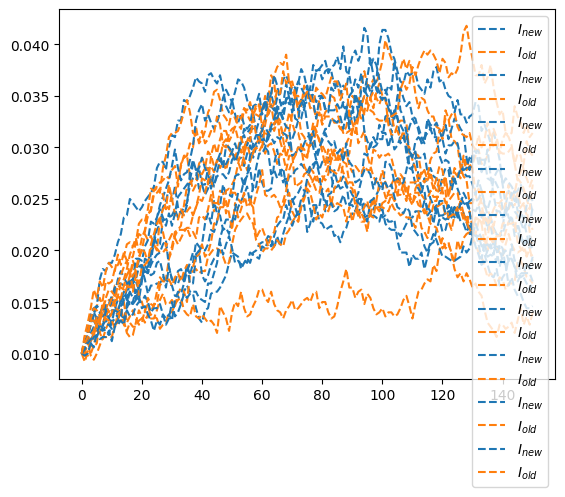

CPU times: user 1min 50s, sys: 395 ms, total: 1min 50s
Wall time: 1min 51s


In [37]:
%%time

import matplotlib.pyplot as plt

alpha = 40

N = 5000
prob = 14.7 / N
i0 = 0.01
t_max = 150
beta_default = 0.3
mu = 0.1
seed=42

t = 500

for i in range(10):
    print("New ", i)
    tt, result = simulate(
        N = N,
        prob = prob,
        i0 = i0,
        t_max = t_max,
        beta_default = beta_default,
        mu = mu,
        alpha=alpha,
        seed=42,
    )

    plt.plot(result["i"][:t], label=r"$I_{new}$", color="C0", linestyle="--")
    print(result["r"][-1])

    print("Old, ", i)
    tt, result = simulate_old()

    plt.plot(result["i"][:t], label=r"$I_{old}$", color="C1", linestyle="--")
    print(result["r"][-1])

    plt.xlim(0, t)
    
plt.legend()
plt.show()


0
No more infected nodes
1
No more infected nodes
2
No more infected nodes
3
No more infected nodes
4
No more infected nodes
5
No more infected nodes
6
No more infected nodes
7
No more infected nodes
8
No more infected nodes
9
No more infected nodes


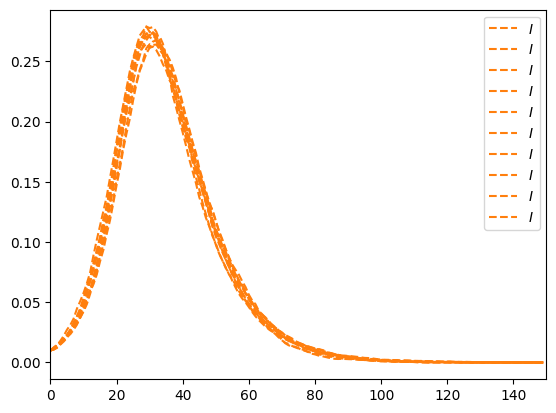

CPU times: user 46.4 s, sys: 255 ms, total: 46.6 s
Wall time: 46.8 s


In [42]:
%%time

import matplotlib.pyplot as plt

alpha = 0

N = int(1e4)
prob = 14.7 / N
i0 = 0.01
t_max = 150
beta_default = 0.3
mu = 0.1
seed=42

t = 150

for i in range(10):
    print(i)
    tt, result = simulate(
        N = N,
        prob = prob,
        i0 = i0,
        t_max = t_max,
        beta_default = beta_default,
        mu = mu,
        alpha=alpha,
        seed=42,
    )

    plt.plot(result["i"][:t], label=r"$I$", color="C1", linestyle="--")

    plt.xlim(0, t)
    
plt.legend()
plt.show()


In [15]:
def simulate_old():
    # Simulates the epidemic. The change in social activity is only computed for infected nodes and
    # their neighbours
    
    G = nx.fast_gnp_random_graph(N, prob, seed=42)

    while not nx.is_connected(G):
        G = nx.fast_gnp_random_graph(N, prob, seed=42)


    # Init
    infected_nodes = set(random.sample([node for node in G.nodes()], max(1, round(N * i0))))
    
    # We need to store the disease status of each node
    G.disease_status={}

    # We need to store theta for each node
    G.theta = {}

    # We need to store the social activity of each node
    G.a={}

    # We need to store the probability of being S for each node
    G.s={}

    # Local prevalence (rho in the paper)
    G.i={}
    
    for i in G:
        # Set social activity to 1 and nodes to their initial status
        G.a[i] = 1
        if i in infected_nodes:
            G.disease_status[i] = "i"
        else:
            G.disease_status[i] = "s"

    k_ave = 2*len(G.edges)/N
    beta = beta_default/k_ave

    result = {"s": [1 - len(infected_nodes)/N],
              "i": [len(infected_nodes)/N],
              "r": [0]}
    
    t = 0
    
    effective_nodes = set() # Only I nodes and their neighbours are relevant

    for i in infected_nodes:
        if i not in effective_nodes:
            effective_nodes.add(i)
        for j in G.neighbors(i):
            if j not in effective_nodes:
                effective_nodes.add(j)

    for t in range(0, t_max):

        dSI = 0
        dIR = 0
        
        # Update theta
        for i in G:
            G.s[i] = sum([1 if G.disease_status[j] == "s" else 0 for j in G.neighbors(i)])/G.degree[i]
            G.i[i] = sum([1 if G.disease_status[j] == "i" else 0 for j in G.neighbors(i)])/G.degree[i]

        # Update social activity a_step times to reach equilibrium
        for _ in range(a_steps):
          for i in G: # Aggregate social activity to react to
                G.theta[i] = sum([G.a[j] for j in G.neighbors(i)])
          for i in G: # Update all social activities
                G.a[i] = 1 / (1 + G.s[i]*G.i[i]*beta*G.theta[i]*delta*(alpha/dt))
        
        infected_add  = set() # Will be added to infected
        effective_add = set() # Will be added to effective
        
        for i in infected_nodes:
            for j in G.neighbors(i):
                if G.disease_status[j]=="s":
                    p=np.random.random()
                    if p<beta*G.a[i]*G.a[j]:
                        G.disease_status[j]="i" # S -> I
                        infected_add.add(j)
                        effective_add.add(j)                       
                        dSI += 1
                        for k in G.neighbors(j): # Add new I node's neighbours to effective
                            if G.disease_status[k] == "s": # Infected nodes are already effective
                                effective_add.add(k)       # recovered nodes should not be effective 

        infected_remove  = set() # Will be removed from infected
        effective_remove = set() # Will be removed from effective
        
        for i in infected_nodes:
            p = np.random.random()
            if p<mu:
                G.disease_status[i]="r" # I -> R
                infected_remove.add(i) # remove from infected
                effective_remove.add(i) # remove from effected
                dIR += 1
                for j in G.neighbors(i):
                    if j in effective_nodes and G.disease_status[j] == "s":
                        if "i" not in [G.disease_status[k] for k in G.neighbors(j)]:
                            effective_remove.add(j)
                            # If the list of the health statuses of the neighbours (k) of the neighbour (j)
                            # of the recovered node (i) doesn't contain any infected node, then the node j
                            # can be removed from the effective nodes.
                            # We also need to check that the node is in the S state, otherwise it could be
                            # an I node (which should be effective) even if it doesn't have I neighbours
                
        for i in infected_add:
            infected_nodes.add(i)
        for i in infected_remove:
            infected_nodes.remove(i)
            
        for i in effective_add:
            if i not in effective_nodes:
                effective_nodes.add(i)
        for i in effective_remove:
                effective_nodes.remove(i)

        result["s"].append(result["s"][-1] - dSI/N)
        result["i"].append(result["i"][-1] + dSI/N - dIR/N)
        result["r"].append(result["r"][-1] + dIR/N)

        t+=1
    
        if len(infected_nodes) == 0:
            # Repeat the last value of s, i and r until the end if the epidemics ends before tmax
            result["s"] = np.pad(result["s"], [(0, t_max+1-len(result["s"]))], mode='edge')
            result["i"] = np.pad(result["i"], [(0, t_max+1-len(result["i"]))], mode='constant') # pad 0
            result["r"] = np.pad(result["r"], [(0, t_max+1-len(result["r"]))], mode='edge')

            break 
    
    tt = np.linspace(0, t_max, t_max+1)
    
    return tt, result


In [106]:
alpha = 0

In [107]:
%%time
tt, result = simulate_old()

CPU times: user 15.4 s, sys: 30.7 ms, total: 15.4 s
Wall time: 15.6 s


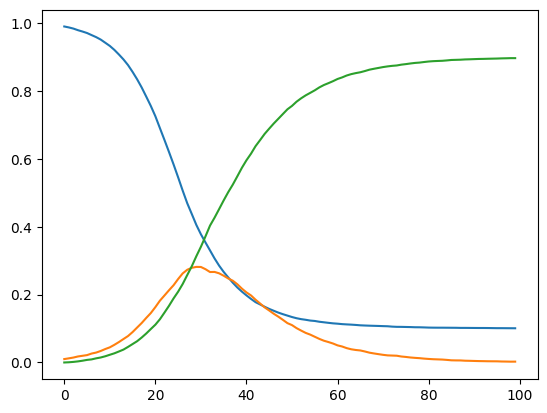

In [108]:
t = 100

plt.plot(result["s"][:t], label="S")
plt.plot(result["i"][0:t], label="I")
plt.plot(result["r"][0:t], label="R")

In [ ]:
# Let's create a matrix "sims_matrix" with N_sims rows and t_max columns,
# each row represents the time-series of a single simulation

sims_matrix = np.zeros((N_sims, t_max+1))

N_keep = 0 # Number of runs in which i is over the threshold
r_inf = []  # Final attack rates list

for i, row in enumerate(sims_matrix):
    tt, result = simulate()

#    if(result["r"][-1] >= frac): # Only keep runs where the desease reaches a significant fraction of the pupulation
    row[:] = result["i"][:]
    r_inf.append(result["r"][-1])

r_inf = np.array(r_inf) # From list to np.array

path = "new_output/" + ("alpha={}/".format(alpha))

if not os.path.exists(path):
    os.makedirs(path)

np.save(path + "simulations", sims_matrix)
np.save(path + "r_inf", r_inf)